<a href="https://colab.research.google.com/github/karthikmswamy/TF_Intro_Notebooks/blob/master/TF_DF_with_Data_Variations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installs

In [ ]:
# !pip install -U augly
# !sudo apt-get install python3-magic
!pip install tensorflow_decision_forests
!pip install wurlitzer

## Imports

In [2]:
from time import time

import tensorflow_decision_forests as tfdf
import pandas as pd
import tensorflow as tf
try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
import matplotlib.pyplot as plt

## Data Download and Check

In [3]:
! wget -O bestBuy.csv "https://raw.githubusercontent.com/SAP-samples/data-attribute-recommendation-postman-tutorial-sample/master/Tutorial_Example_Dataset.csv"

# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv("./bestBuy.csv", usecols=['manufacturer', 'price', 'level1_category'])

# Display the first 3 examples.
dataset_df.head(3)

--2021-07-20 13:30:43--  https://raw.githubusercontent.com/SAP-samples/data-attribute-recommendation-postman-tutorial-sample/master/Tutorial_Example_Dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9921374 (9.5M) [text/plain]
Saving to: ‘bestBuy.csv’

bestBuy.csv         100%[===================>]   9.46M  35.0MB/s    in 0.3s    

2021-07-20 13:30:43 (35.0 MB/s) - ‘bestBuy.csv’ saved [9921374/9921374]



,manufacturer,price,level1_category
0,Duracell,5.49,Connected Home & Housewares
1,Duracell,5.49,Connected Home & Housewares
2,Duracell,7.49,Connected Home & Housewares


In [4]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48087 entries, 0 to 48086
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   manufacturer     48023 non-null  object 
 1   price            48087 non-null  float64
 2   level1_category  47906 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [5]:
# Name of the label column.
label = "level1_category"

classes = dataset_df[label].unique().tolist()
print(f"Label classes: {classes}")

dataset_df[label] = dataset_df[label].map(classes.index)

Label classes: ['Connected Home & Housewares', nan, 'Car Electronics & GPS', 'Musical Instruments', 'Toys, Games & Drones', 'Video Games', 'Cameras & Camcorders', 'Computers & Tablets', 'Appliances', 'Audio', 'TV & Home Theater', 'Health, Fitness & Beauty', 'Name Brands', 'Cell Phones', 'Movies & Music', 'Magnolia Home Theater', 'Geek Squad', 'Best Buy Gift Cards', 'Wearable Technology', 'Gift Ideas', 'Housewares']


## Helper Methods

In [6]:
# Split the dataset into a training and a testing dataset.
# Test split remains a constant 
def split_dataset(dataset, num_train=10000):
  """Splits a panda dataframe in two."""
  dataset = dataset.sample(frac=1.0, random_state=1729)
  
  test_dataset = dataset[40000:]
  train_dataset = dataset[:num_train]
  
  return train_dataset, test_dataset

In [7]:
def train_rf_model_with_dataframes(train_df, test_df, label):
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label=label)

    # Specify the model.
    model_1 = tfdf.keras.RandomForestModel(num_trees=30)

    # Optionally, add evaluation metrics.
    model_1.compile(metrics=["accuracy"])

    t1 = time()
    # Train the model.
    with sys_pipes():
        model_1.fit(x=train_ds)

    evaluation = model_1.evaluate(test_ds)

    # print(f"Loss: {evaluation[0]}")
    print(f"Accuracy: {evaluation[1]} in {time() - t1} secs")
    return evaluation[1], time() - t1

In [8]:
def train_gbdt_model_with_dataframes(train_df, test_df, label):
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label=label)

    # Specify the model.
    model_1 = tfdf.keras.GradientBoostedTreesModel(num_trees=30)

    # Optionally, add evaluation metrics.
    model_1.compile(metrics=["accuracy"])

    t1 = time()
    # Train the model.
    with sys_pipes():
        model_1.fit(x=train_ds)

    evaluation = model_1.evaluate(test_ds)

    # print(f"Loss: {evaluation[0]}")
    print(f"Accuracy: {evaluation[1]} in {time() - t1} secs")
    return evaluation[1], time() - t1

In [9]:
def train_cart_model_with_dataframes(train_df, test_df, label):
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label=label)

    # Specify the model.
    model_1 = tfdf.keras.CartModel()

    # Optionally, add evaluation metrics.
    model_1.compile(metrics=["accuracy"])

    t1 = time()
    # Train the model.
    with sys_pipes():
        model_1.fit(x=train_ds)

    evaluation = model_1.evaluate(test_ds)

    # print(f"Loss: {evaluation[0]}")
    print(f"Accuracy: {evaluation[1]} in {time() - t1} secs")
    return evaluation[1], time() - t1

## Train with Different Records

In [10]:
def train_and_evaluate_on_data(num_train, results_rf, results_gb, results_cm):
    train_ds_pd, test_ds_pd = split_dataset(dataset_df, num_train)
    print(f"{len(train_ds_pd)} examples in training, {len(test_ds_pd)} examples for testing.")

    accuracy, time_taken = train_rf_model_with_dataframes(train_ds_pd, test_ds_pd, label)
    results_rf.append([num_train, accuracy, time_taken])

    accuracy, time_taken = train_gbdt_model_with_dataframes(train_ds_pd, test_ds_pd, label)
    results_gb.append([num_train, accuracy, time_taken])

    accuracy, time_taken = train_cart_model_with_dataframes(train_ds_pd, test_ds_pd, label)
    results_cm.append([num_train, accuracy, time_taken])

    return results_rf, results_gb, results_cm

In [11]:
results_rf, results_gb, results_cm = [], [], []
num_train_list = [500, 1000, 2000, 4000, 8000, 16000, 32000, 40000]
for num_train in num_train_list:
    results_rf, results_gb, results_cm = train_and_evaluate_on_data(num_train, results_rf, results_gb, results_cm)

500 examples in training, 8087 examples for testing.


2021-07-20 13:30:49.287148: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-20 13:30:49.290940: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299995000 Hz


8/8 [==============================] - 5s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 8
[INFO kernel.cc:393] Number of examples: 500
[INFO data_spec_inference.cc:289] 287 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (15 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 500
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:1 (0.2%) has-dict vocab-size:16 num-oods:287 (57.515%) most-frequent:"<OOD>" 287 (57.515%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:20 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:253.683 min:1.49 max:12300 sd:711.486

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute w

127/127 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.2808
Accuracy: 0.2808210849761963 in 8.342710018157959 secs
8/8 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 8
[INFO kernel.cc:393] Number of examples: 500
[INFO data_spec_inference.cc:289] 287 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (15 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 500
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:1 (0.2%) has-dict vocab-size:16 num-oods:287 (57.515%) most-frequent:"<OOD>" 287 (57.515%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:20 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:253.683 min:1.49 max:12300 sd:711.486

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute w

127/127 [==============================] - 1s 4ms/step - loss: 0.0000e+00 - accuracy: 0.3152
Accuracy: 0.315197229385376 in 1.3797359466552734 secs
8/8 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 8
[INFO kernel.cc:393] Number of examples: 500
[INFO data_spec_inference.cc:289] 287 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (15 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 500
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:1 (0.2%) has-dict vocab-size:16 num-oods:287 (57.515%) most-frequent:"<OOD>" 287 (57.515%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:20 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:253.683 min:1.49 max:12300 sd:711.486

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute w

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.2383
Accuracy: 0.2382836639881134 in 0.6427614688873291 secs
1000 examples in training, 8087 examples for testing.
16/16 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 16
[INFO kernel.cc:393] Number of examples: 1000
[INFO data_spec_inference.cc:289] 449 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (36 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 1000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:1 (0.1%) has-dict vocab-size:37 num-oods:449 (44.9449%) most-frequent:"<OOD>" 449 (44.9449%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:20 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:262.11 min:1.49 max:12300 sd:660.015

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribu

127/127 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.3773
Accuracy: 0.3772721588611603 in 0.8515772819519043 secs
16/16 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 16
[INFO kernel.cc:393] Number of examples: 1000
[INFO data_spec_inference.cc:289] 449 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (36 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 1000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:1 (0.1%) has-dict vocab-size:37 num-oods:449 (44.9449%) most-frequent:"<OOD>" 449 (44.9449%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:20 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:262.11 min:1.49 max:12300 sd:660.015

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribu

127/127 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - accuracy: 0.3874
Accuracy: 0.387411892414093 in 1.8938877582550049 secs
16/16 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 16
[INFO kernel.cc:393] Number of examples: 1000
[INFO data_spec_inference.cc:289] 449 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (36 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 1000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:1 (0.1%) has-dict vocab-size:37 num-oods:449 (44.9449%) most-frequent:"<OOD>" 449 (44.9449%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:20 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:262.11 min:1.49 max:12300 sd:660.015

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribu

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3054
Accuracy: 0.30542847514152527 in 0.6774287223815918 secs
2000 examples in training, 8087 examples for testing.
32/32 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 32
[INFO kernel.cc:393] Number of examples: 2000
[INFO data_spec_inference.cc:289] 614 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (88 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 2000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:3 (0.15%) has-dict vocab-size:89 num-oods:614 (30.7461%) most-frequent:"<OOD>" 614 (30.7461%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:20 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:253.659 min:0.01 max:12300 sd:640.932

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attri

127/127 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.4635
Accuracy: 0.46345987915992737 in 1.7955348491668701 secs
32/32 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 32
[INFO kernel.cc:393] Number of examples: 2000
[INFO data_spec_inference.cc:289] 614 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (88 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 2000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:3 (0.15%) has-dict vocab-size:89 num-oods:614 (30.7461%) most-frequent:"<OOD>" 614 (30.7461%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:20 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:253.659 min:0.01 max:12300 sd:640.932

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attri

127/127 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - accuracy: 0.4757
Accuracy: 0.4757017493247986 in 2.2559468746185303 secs
32/32 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 32
[INFO kernel.cc:393] Number of examples: 2000
[INFO data_spec_inference.cc:289] 614 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (88 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 2000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:3 (0.15%) has-dict vocab-size:89 num-oods:614 (30.7461%) most-frequent:"<OOD>" 614 (30.7461%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:20 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:253.659 min:0.01 max:12300 sd:640.932

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attri

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.4513
Accuracy: 0.4513416588306427 in 0.7589678764343262 secs
4000 examples in training, 8087 examples for testing.
63/63 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 63
[INFO kernel.cc:393] Number of examples: 4000
[INFO data_spec_inference.cc:289] 759 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (212 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 4000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:5 (0.125%) has-dict vocab-size:213 num-oods:759 (18.9987%) most-frequent:"<OOD>" 759 (18.9987%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:20 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:260.872 min:0.01 max:12300 sd:631.2

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attr

127/127 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5918
Accuracy: 0.5918140411376953 in 2.4782557487487793 secs
63/63 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 63
[INFO kernel.cc:393] Number of examples: 4000
[INFO data_spec_inference.cc:289] 759 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (212 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 4000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:5 (0.125%) has-dict vocab-size:213 num-oods:759 (18.9987%) most-frequent:"<OOD>" 759 (18.9987%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:20 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:260.872 min:0.01 max:12300 sd:631.2

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attr

127/127 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - accuracy: 0.5995
Accuracy: 0.5994806289672852 in 3.07039213180542 secs
63/63 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 63
[INFO kernel.cc:393] Number of examples: 4000
[INFO data_spec_inference.cc:289] 759 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (212 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 4000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:5 (0.125%) has-dict vocab-size:213 num-oods:759 (18.9987%) most-frequent:"<OOD>" 759 (18.9987%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:20 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:260.872 min:0.01 max:12300 sd:631.2

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attr

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5731
Accuracy: 0.5731420516967773 in 0.8729896545410156 secs
8000 examples in training, 8087 examples for testing.
125/125 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 125
[INFO kernel.cc:393] Number of examples: 8000
[INFO data_spec_inference.cc:289] 906 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (381 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 8000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:8 (0.1%) has-dict vocab-size:382 num-oods:906 (11.3363%) most-frequent:"<OOD>" 906 (11.3363%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:20 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:256.176 min:0.01 max:12300 sd:586.041

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Att

127/127 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.6872
Accuracy: 0.6871522068977356 in 23.577579259872437 secs
125/125 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 125
[INFO kernel.cc:393] Number of examples: 8000
[INFO data_spec_inference.cc:289] 906 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (381 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 8000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:8 (0.1%) has-dict vocab-size:382 num-oods:906 (11.3363%) most-frequent:"<OOD>" 906 (11.3363%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:20 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:256.176 min:0.01 max:12300 sd:586.041

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Att

127/127 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 0.6937
Accuracy: 0.6937059760093689 in 131.69450116157532 secs
125/125 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 125
[INFO kernel.cc:393] Number of examples: 8000
[INFO data_spec_inference.cc:289] 906 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (381 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 8000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:8 (0.1%) has-dict vocab-size:382 num-oods:906 (11.3363%) most-frequent:"<OOD>" 906 (11.3363%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:20 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:256.176 min:0.01 max:12300 sd:586.041

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Att

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.6115
Accuracy: 0.6114752292633057 in 1.8574111461639404 secs
16000 examples in training, 8087 examples for testing.
250/250 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 250
[INFO kernel.cc:393] Number of examples: 16000
[INFO data_spec_inference.cc:289] 1024 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (626 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 16000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:18 (0.1125%) has-dict vocab-size:627 num-oods:1024 (6.40721%) most-frequent:"<OOD>" 1024 (6.40721%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:21 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:255.794 min:0.01 max:18000 sd:590.45

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defi

127/127 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.7564
Accuracy: 0.7563991546630859 in 82.80359506607056 secs
250/250 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 250
[INFO kernel.cc:393] Number of examples: 16000
[INFO data_spec_inference.cc:289] 1024 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (626 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 16000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:18 (0.1125%) has-dict vocab-size:627 num-oods:1024 (6.40721%) most-frequent:"<OOD>" 1024 (6.40721%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:21 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:255.794 min:0.01 max:18000 sd:590.45

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defi

127/127 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.7581
Accuracy: 0.7581303119659424 in 263.0507712364197 secs
250/250 [==============================] - 0s 953us/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 250
[INFO kernel.cc:393] Number of examples: 16000
[INFO data_spec_inference.cc:289] 1024 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (626 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 16000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:18 (0.1125%) has-dict vocab-size:627 num-oods:1024 (6.40721%) most-frequent:"<OOD>" 1024 (6.40721%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:21 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:255.794 min:0.01 max:18000 sd:590.45

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defi

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.6724
Accuracy: 0.6724372506141663 in 2.787523031234741 secs
32000 examples in training, 8087 examples for testing.
500/500 [==============================] - 1s 999us/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 500
[INFO kernel.cc:393] Number of examples: 32000
[INFO data_spec_inference.cc:289] 1144 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (931 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 32000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:44 (0.1375%) has-dict vocab-size:932 num-oods:1144 (3.57992%) most-frequent:"<OOD>" 1144 (3.57992%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:21 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:253.956 min:0.01 max:18000 sd:575.973

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-def

127/127 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.8149
Accuracy: 0.8148881196975708 in 82.7915563583374 secs
500/500 [==============================] - 1s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 500
[INFO kernel.cc:393] Number of examples: 32000
[INFO data_spec_inference.cc:289] 1144 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (931 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 32000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:44 (0.1375%) has-dict vocab-size:932 num-oods:1144 (3.57992%) most-frequent:"<OOD>" 1144 (3.57992%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:21 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:253.956 min:0.01 max:18000 sd:575.973

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-def

127/127 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.7893
Accuracy: 0.7892914414405823 in 370.16597843170166 secs
500/500 [==============================] - 1s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 500
[INFO kernel.cc:393] Number of examples: 32000
[INFO data_spec_inference.cc:289] 1144 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (931 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 32000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:44 (0.1375%) has-dict vocab-size:932 num-oods:1144 (3.57992%) most-frequent:"<OOD>" 1144 (3.57992%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:21 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:253.956 min:0.01 max:18000 sd:575.973

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-def

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.7515
Accuracy: 0.7514529228210449 in 5.532477140426636 secs
40000 examples in training, 8087 examples for testing.
625/625 [==============================] - 1s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 625
[INFO kernel.cc:393] Number of examples: 40000
[INFO data_spec_inference.cc:289] 1153 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (1045 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 40000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:52 (0.13%) has-dict vocab-size:1046 num-oods:1153 (2.88625%) most-frequent:"<OOD>" 1153 (2.88625%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:22 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:255.547 min:0.01 max:28000 sd:588.007

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-def

127/127 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.8313
Accuracy: 0.8313342332839966 in 142.542662858963 secs
625/625 [==============================] - 1s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 625
[INFO kernel.cc:393] Number of examples: 40000
[INFO data_spec_inference.cc:289] 1153 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (1045 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 40000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:52 (0.13%) has-dict vocab-size:1046 num-oods:1153 (2.88625%) most-frequent:"<OOD>" 1153 (2.88625%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:22 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:255.547 min:0.01 max:28000 sd:588.007

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-def

127/127 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8002
Accuracy: 0.8001731038093567 in 443.1349506378174 secs
625/625 [==============================] - 1s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 625
[INFO kernel.cc:393] Number of examples: 40000
[INFO data_spec_inference.cc:289] 1153 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (1045 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 40000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "manufacturer" CATEGORICAL num-nas:52 (0.13%) has-dict vocab-size:1046 num-oods:1153 (2.88625%) most-frequent:"<OOD>" 1153 (2.88625%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:22 no-ood-item

NUMERICAL: 1 (33.3333%)
	1: "price" NUMERICAL mean:255.547 min:0.01 max:28000 sd:588.007

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-def

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.7667
Accuracy: 0.7666625380516052 in 4.98656702041626 secs


## Plotting Results

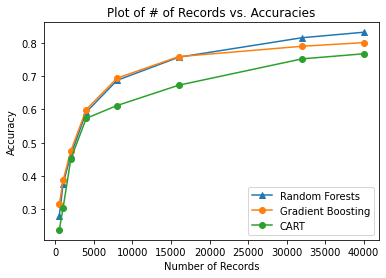

In [12]:
x  = [res[0] for res in results_rf]
y1 = [res[1] for res in results_rf]
y2 = [res[1] for res in results_gb]
y3 = [res[1] for res in results_cm]
plt.plot(x, y1, label="Random Forests", marker='^')
plt.plot(x, y2, label="Gradient Boosting", marker='o')
plt.plot(x, y3, label="CART", marker='o')
plt.plot()

plt.xlabel("Number of Records")
plt.ylabel("Accuracy")
plt.title("Plot of # of Records vs. Accuracies")
plt.legend()
plt.show()

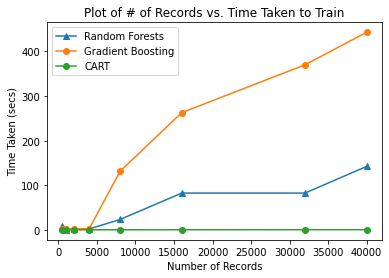

In [13]:
x  = [res[0] for res in results_rf]
y1 = [res[2] for res in results_rf]
y2 = [res[2] for res in results_gb]
y3 = [res[1] for res in results_cm]
plt.plot(x, y1, label="Random Forests", marker='^')
plt.plot(x, y2, label="Gradient Boosting", marker='o')
plt.plot(x, y3, label="CART", marker='o')
plt.plot()

plt.xlabel("Number of Records")
plt.ylabel("Time Taken (secs)")
plt.title("Plot of # of Records vs. Time Taken to Train")
plt.legend()
plt.show()